# Natural Language Processing with Deep Learning

__This is exactly the same notebook as in `../week10_textconv/.`__

__Feel free submit the seminar notebook, just make sure you read the assignments at the end.__

Today we're gonna apply the newly learned DL tools for sequence processing to the task of predicting job salary.

Special thanks to [Oleg Vasilev](https://github.com/Omrigan/) for the assignment core (orignally written for theano/tensorflow).

In [1]:
import sys
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

### About the challenge
For starters, let's download the data from __[here](https://yadi.sk/d/vVEOWPFY3NruT7)__.

You can also get it from the competition [page](https://www.kaggle.com/c/job-salary-prediction/data) (in that case, pick `Train_rev1.*`).


Our task is to predict one number, __SalaryNormalized__, in the sense of minimizing __Mean Absolute Error__.

<img src="https://kaggle2.blob.core.windows.net/competitions/kaggle/3342/media/salary%20prediction%20engine%20v2.png" width=400px>

To do so, our model ca access a number of features:
* Free text: __`Title`__ and  __`FullDescription`__
* Categorical: __`Category`__, __`Company`__, __`LocationNormalized`__, __`ContractType`__, and __`ContractTime`__.


You can read more [in the official description](https://www.kaggle.com/c/job-salary-prediction#description).

In [2]:
data = pd.read_csv("./Train_rev1.csv", index_col=None)
data['Log1pSalary'] = np.log1p(data['SalaryNormalized']).astype('float32')

text_columns = ["Title", "FullDescription"]
categorical_columns = ["Category", "Company", "LocationNormalized", "ContractType", "ContractTime"]
target_column = "Log1pSalary"
data[categorical_columns] = data[categorical_columns].fillna('NaN') # cast nan to string

data.sample(3)

,Id,Title,FullDescription,LocationRaw,LocationNormalized,ContractType,ContractTime,Company,Category,SalaryRaw,SalaryNormalized,SourceName,Log1pSalary
105394,69577905,GRADUATE SALES EXECUTIVE / GRADUATE ACCOUNT EX...,GRADUATE SALES EXECUTIVE / GRADUATE ACCOUNT EX...,South Yorkshire - Sheffield,Sheffield,full_time,permanent,UKStaffsearch,"PR, Advertising & Marketing Jobs",23000 - 30000,26500,ukstaffsearch.com,10.184937
129395,70145797,Hotel Reservationist,Be Part of a NEW Sales Office TEAM Working wit...,"Crawley, West Sussex West Sussex South East",Crawley,NaN,NaN,Ramada Plaza London Gatwick,Hospitality & Catering Jobs,"From 12,646 to 14,500 per annum",13573,caterer.com,9.515911
71779,68837528,Head Chef – Cambridge Hotel ****/****Bonus,Head Chef – Cambridge Hotel ****/****Bonus Th...,Cambridge Cambridgeshire East Anglia,UK,NaN,NaN,Select Hospitality,Hospitality & Catering Jobs,"From 25,000 to 30,000 per annum",27500,caterer.com,10.221977


### The NLP part

To even begin training our neural network, we're gonna need to preprocess the text features: tokenize it and build the token vocabularies.

Since it is not an NLP course, we're gonna use simple built-in NLTK tokenization.

In [3]:
print("Before")
print(data["Title"][::100000])

Before
0         Engineering Systems Analyst
100000                   HR Assistant
200000           Senior EC&I Engineer
Name: Title, dtype: object


In [4]:
import nltk
tokenizer = nltk.tokenize.WordPunctTokenizer()

for col in text_columns:
    data[col] = data[col].apply(lambda l: ' '.join(tokenizer.tokenize(str(l).lower())))

Now we can assume that our text is a space-separated list of tokens:

In [5]:
print("After")
print(data["Title"][::100000])

After
0         engineering systems analyst
100000                   hr assistant
200000         senior ec & i engineer
Name: Title, dtype: object


Not all words are equally useful. Some of them are typos or rare words that are only present a few times. 

Let's see how many times is each word present in the data so that we can build a "white list" of known words.

In [6]:
from collections import Counter
token_counts = Counter()

# Count how many times does each token occur in both "Title" and "FullDescription" fields
for col in text_columns:
    for sentence in data[col]:
        token_counts.update(sentence.split())

In [7]:
print("Total unique tokens :", len(token_counts))
print('\n'.join(map(str, token_counts.most_common(n=5))))
print('...')
print('\n'.join(map(str, token_counts.most_common()[-3:])))

assert token_counts.most_common(1)[0][1] in  range(2600000, 2700000)
assert len(token_counts) in range(200000, 210000)
print('Correct!')

Total unique tokens : 202704
('and', 2657388)
('.', 2523216)
(',', 2318606)
('the', 2080994)
('to', 2019884)
...
('stephanietraveltraderecruitmnt', 1)
('ruabon', 1)
('lowehays', 1)
Correct!


Text(0.5,0,'Counts')

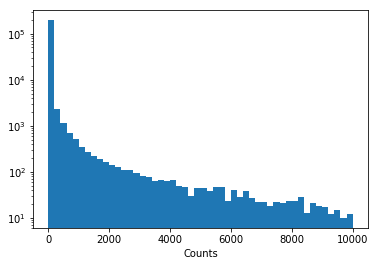

In [8]:
# Let's see how many words are there for each count

_=plt.hist(list(token_counts.values()), range=[0, 10**4], bins=50, log=True)
plt.xlabel("Counts")

__Task 1.1__ Get a list of all tokens that occur at least 10 times.

In [9]:
min_count = 10

# tokens from token_counts keys that had at least min_count occurrences throughout the dataset
tokens = [word for word, value in token_counts.items() if value >= min_count]

# Add a special tokens for unknown and empty words
UNK, PAD = "UNK", "PAD"
tokens = [UNK, PAD] + tokens

In [10]:
print("Tokens left:", len(tokens))
assert type(tokens)==list
assert len(tokens) in range(32000,35000)
assert 'me' in tokens
assert UNK in tokens
print("Correct!")

Tokens left: 34158
Correct!


__Task 1.2__ Build an inverse token index: a dictionary from token(string) to it's index in `tokens` (int)

In [11]:
token_to_id = {word: idx for idx, word in enumerate(tokens)}

In [12]:
assert isinstance(token_to_id, dict)
assert len(token_to_id) == len(tokens)
for tok in tokens:
    assert tokens[token_to_id[tok]] == tok

print("Correct!")

Correct!


And finally, let's use the vocabulary you've built to map text lines into torch-digestible matrices.

In [13]:
UNK_IX, PAD_IX = map(token_to_id.get, [UNK, PAD])

def as_matrix(sequences, max_len=None):
    """ Convert a list of tokens into a matrix with padding """
    if isinstance(sequences[0], str):
        sequences = list(map(str.split, sequences))
        
    max_len = min(max(map(len, sequences)), max_len or float('inf'))
    
    matrix = np.full((len(sequences), max_len), np.int32(PAD_IX))
    for i,seq in enumerate(sequences):
        row_ix = [token_to_id.get(word, UNK_IX) for word in seq[:max_len]]
        matrix[i, :len(row_ix)] = row_ix
    
    return matrix

In [14]:
#### print("Lines:")
print('\n'.join(data["Title"][::100000].values), end='\n\n')
print("Matrix:")
print(as_matrix(data["Title"][::100000]))

engineering systems analyst
hr assistant
senior ec & i engineer

Matrix:
[[   2    3    4    1    1]
 [ 998  176    1    1    1]
 [  18 3472  242   59    6]]


Now let's  encode the categirical data we have.

As usual, we shall use one-hot encoding for simplicity. Kudos if you implement tf-idf, target averaging or pseudo-counter-based encoding.

In [15]:
from sklearn.feature_extraction import DictVectorizer

# we only consider top-1k most frequent companies to minimize memory usage
top_companies, top_counts = zip(*Counter(data['Company']).most_common(1000))
recognized_companies = set(top_companies)
data["Company"] = data["Company"].apply(lambda comp: comp if comp in recognized_companies else "Other")

categorical_vectorizer = DictVectorizer(dtype=np.float32, sparse=False)
categorical_vectorizer.fit(data[categorical_columns].apply(dict, axis=1))

DictVectorizer(dtype=<class 'numpy.float32'>, separator='=', sort=True,
        sparse=False)

### The data science part

Once we've learned to tokenize the data, let's design a machine learning experiment.

As before, we won't focus too much on validation, opting for a simple train-test split.

__To be completely rigorous,__ we've comitted a small crime here: we used the whole data for tokenization and vocabulary building. A more strict way would be to do that part on training set only. You may want to do that and measure the magnitude of changes.

In [16]:
from sklearn.model_selection import train_test_split

data_train, data_val = train_test_split(data, test_size=0.1, random_state=42)

print("Train size = ", len(data_train))
print("Validation size = ", len(data_val))

Train size =  220291
Validation size =  24477


In [17]:
def generate_batch(data, batch_size=None, replace=True, max_len=None):
    """
    Creates a pytorch-friendly dict from the batch data.
    :returns: a dict with {'title' : int64[batch, title_max_len]
    """
    if batch_size is not None:
        data = data.sample(batch_size, replace=replace)
    
    batch = {}
    for col in text_columns:
        batch[col] = as_matrix(data[col].values, max_len)
    
    batch['Categorical'] = categorical_vectorizer.transform(data[categorical_columns].apply(dict, axis=1))
    
    if target_column in data.columns:
        batch[target_column] = data[target_column].values
    
    return batch

In [18]:
generate_batch(data_train, 3, max_len=10)

{'Categorical': array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.]], dtype=float32),
 'FullDescription': array([[  561,  1588,  1595,   321,   262,  1589,  1566,  2497,  1433,
          1617],
        [  217, 12331,    86,  8234,    15,  2133,  3181,  2241,   561,
         13453],
        [ 3030,  1166,  1681,  2335,    11,   288,  1527,  1166,    74,
            74]], dtype=int32),
 'Log1pSalary': array([10.571342,  9.672878,  9.741028], dtype=float32),
 'Title': array([[ 429, 1468,   88,    1,    1],
        [1849, 4502,   11, 3221,  622],
        [1681,  288,   63,  313,   64]], dtype=int32)}

### Finally, let's talk deep learning

Out model consists of three branches:
* Title encoder
* Description encoder
* Categorical features encoder

We will then feed all 3 branches into one common network that predicts salary.

![scheme](https://github.com/yandexdataschool/Practical_DL/raw/master/homework04/conv_salary_architecture.png)

By default, both text vectorizers shall use 1d convolutions, followed by global pooling over time.

In [19]:
import torch, torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

class GlobalMaxPooling(nn.Module):
    def __init__(self, dim=-1):
        super(self.__class__, self).__init__()
        self.dim = dim
        
    def forward(self, x):
        return x.max(dim=self.dim)[0]
    
class GlobalAvgPooling(nn.Module):
    def __init__(self, dim=-1):
        super(self.__class__, self).__init__()
        self.dim = dim
        
    def forward(self, x):
        return x.mean(dim=self.dim)
    
class SequenceWise(nn.Module):
    def __init__(self, module):
        super().__init__()
        self.module = module

    def forward(self, x):
        t, n = x.size(0), x.size(1)
        x = x.view(t * n, -1)
        x = self.module(x)
        x = x.view(t, n, -1)
        return x


class BatchBiRNN(nn.Module):
    def __init__(self, input_size, hidden_size, rnn_type=nn.GRU):
        super().__init__()
        self.batch_norm = SequenceWise(nn.BatchNorm1d(input_size))
        self.rnn = rnn_type(input_size=input_size, hidden_size=hidden_size, bidirectional=True, bias=False)
        self.projection = SequenceWise(nn.Linear(2 * hidden_size, hidden_size))

    def flatten_parameters(self):
        self.rnn.flatten_parameters()

    def forward(self, x):
        x = self.batch_norm(x)
        x, _ = self.rnn(x)
        return self.projection(x)
    
class AttentivePooling(nn.Module):
    def __init__(self, hidden_size):
        super().__init__()
        self.weights_calculator = SequenceWise(nn.Sequential(
            nn.Linear(hidden_size, hidden_size, bias=False),
            nn.BatchNorm1d(hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 1),
        ))
        self.softmax = nn.Softmax(dim=1)
        
    def forward(self, x):
        weights = self.weights_calculator(x)
        weights = self.softmax(weights)
        return (x * weights).sum(1)

class SoftmaxPooling(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim
        self.softmax = nn.Softmax(dim)
    
    def forward(self, x):
        return (x * self.softmax(x)).sum(self.dim)

In [92]:
class TextEncoder(nn.Module):
    def __init__(self, n_tokens=len(tokens), hidden_size=64):
        """ 
        A simple sequential encoder for titles.
        x -> emb -> conv -> global_max -> relu -> dense
        """
        super(self.__class__, self).__init__()
        self._hidden_size = hidden_size
        self.embedding = nn.Embedding(n_tokens, hidden_size, padding_idx=PAD_IX)
        self.convnet = nn.Sequential(
            nn.Conv1d(hidden_size, hidden_size, kernel_size=3, padding=1),
            nn.BatchNorm1d(hidden_size),
            nn.ReLU(),
            nn.Conv1d(hidden_size, hidden_size, kernel_size=3, padding=1),
            nn.BatchNorm1d(hidden_size),
            nn.ReLU()
        )
        self.pooling = GlobalMaxPooling(dim=1)
        
    @property
    def out_size(self):
        return self._hidden_size

    def forward(self, text_ix):
        """
        :param text_ix: int64 Variable of shape [batch_size, max_len]
        :returns: float32 Variable of shape [batch_size, out_size]
        """
        h = self.embedding(text_ix)

        # we transpose from [batch, time, units] to [batch, units, time] to fit Conv1d dim order
        h = h.transpose(1, 2)
        h = self.convnet(h)
        h = h.transpose(1, 2).contiguous()
        return self.pooling(h)

In [93]:
class RNNTextEncoder(nn.Module):
    def __init__(self, n_tokens=len(tokens), hidden_size=256, num_layers=3):
        super().__init__()
        self._hidden_size = hidden_size
        self.embedding = nn.Embedding(n_tokens, hidden_size, padding_idx=PAD_IX)
        rnn_list = []
        for _ in range(num_layers):
            rnn_list.append(BatchBiRNN(hidden_size, hidden_size))
        self.rnns = nn.Sequential(*rnn_list)
        self.pooling = AttentivePooling(hidden_size)
        
    @property
    def out_size(self):
        return self._hidden_size
    
    def forward(self, text_ix):
        hidden = self.embedding(text_ix)
        hidden = torch.transpose(hidden, 0, 1).contiguous()
        hidden = self.rnns(hidden)
        hidden = torch.transpose(hidden, 0, 1).contiguous()
        return self.pooling(hidden)

In [94]:
def test_title_encoder(title_encoder):
    dummy_x = Variable(torch.LongTensor(generate_batch(data_train, 3)['Title']))
    dummy_v = title_encoder(dummy_x)

    assert isinstance(dummy_v, Variable)
    assert tuple(dummy_v.shape) == (dummy_x.shape[0], 64)

    del title_encoder
    print("Seems fine")

In [95]:
# test_title_encoder(TextEncoder())
# test_title_encoder(RNNTextEncoder(hidden_size=64))

__Task 2.1__ Create description encoder

In [96]:
def test_desc_encoder(desc_encoder):
    dummy_x = Variable(torch.LongTensor(generate_batch(data_train, 3)['FullDescription']))
    dummy_v = desc_encoder(dummy_x)

    assert isinstance(dummy_v, Variable)
    assert tuple(dummy_v.shape) == (dummy_x.shape[0], 64)
    del desc_encoder
    print("Seems fine too")

In [97]:
# test_desc_encoder(TextEncoder())
# test_desc_encoder(RNNTextEncoder(hidden_size=64))

__ Task 2.2__ Build one network ~~to rule them all~~

In [98]:
import sys
class FullNetwork(nn.Module):
    """
    This class does all the steps from (title, desc, categorical) features -> predicted target
    It unites title & desc encoders you defined above as long as some layers for head and categorical branch.
    """
    
    def __init__(self, title_encoder, desc_encoder, n_cat_features=len(categorical_vectorizer.vocabulary_)):
        super(self.__class__, self).__init__()
        
        self.title_encoder = title_encoder
        self.desc_encoder = desc_encoder
        
        self.cat_encoder = nn.Sequential(
            nn.Linear(n_cat_features, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
        )
        
        self.output_network = nn.Sequential(
            nn.Linear(title_encoder.out_size + desc_encoder.out_size + 256, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Linear(256, 1),
            nn.ReLU(),
        )
        
        
    def forward(self, title_ix, desc_ix, cat_features):
        """
        :param title_ix: int32 Variable [batch, title_len], job titles encoded by as_matrix
        :param desc_ix:  int32 Variable [batch, desc_len] , job descriptions encoded by as_matrix
        :param cat_features: float32 Variable [batch, n_cat_features]
        :returns: float32 Variable 1d [batch], predicted log1p-salary
        """
        
        title_h = self.title_encoder(title_ix)
        desc_h = self.desc_encoder(desc_ix)
        cat_h = self.cat_encoder(cat_features)
        joint_h = torch.cat([title_h, desc_h, cat_h], dim=1)

        joint_h = self.output_network(joint_h)

        return joint_h[:, 0]

In [99]:
title_encoder = TextEncoder(hidden_size=128)
desc_encoder = TextEncoder(hidden_size=128)
model = FullNetwork(title_encoder, desc_encoder).cuda()
opt = torch.optim.Adam(model.parameters(), lr=1e-3)

In [100]:
# # test it on one batch

# batch = generate_batch(data_train, 64)

# title_ix = Variable(torch.LongTensor(batch["Title"])).cuda()
# desc_ix = Variable(torch.LongTensor(batch["FullDescription"])).cuda()
# cat_features = Variable(torch.FloatTensor(batch["Categorical"])).cuda()
# reference = Variable(torch.FloatTensor(batch[target_column])).cuda()

# prediction = model(title_ix, desc_ix, cat_features)

# assert len(prediction.shape) == 1 and prediction.shape[0] == title_ix.shape[0]

In [101]:
def compute_loss(reference, prediction):
    """
    Computes objective for minimization.
    By deafult we minimize MSE, but you are encouraged to try mix up MSE, MAE, huber loss, etc.
    """
    return torch.mean((prediction - reference) ** 2)

def compute_mae(reference, prediction):
    """ Compute MAE on actual salary, assuming your model outputs log1p(salary)"""
    return torch.abs(torch.exp(reference - 1) - torch.exp(prediction - 1)).mean()

In [102]:
# loss = compute_loss(reference, prediction)
# dummy_grads = torch.autograd.grad(loss, model.parameters(), retain_graph=True)
# for grad in dummy_grads:
#     assert grad is not None and not (grad == 0).all(), "Some model parameters received zero grads. " \
#                                                        "Double-check that your model uses all it's layers."

### Let's train it!

In [103]:
from tqdm import tnrange
from IPython.display import display
def iterate_minibatches(data, batch_size=32, max_len=None,
                        max_batches=None, shuffle=True, verbose=True):
    indices = np.arange(len(data))
    if shuffle:
        indices = np.random.permutation(indices)
    if max_batches is not None:
        indices = indices[: batch_size * max_batches]
        
    irange = tnrange if verbose else range
    
    for start in irange(0, len(indices), batch_size):
        yield generate_batch(data.iloc[indices[start : start + batch_size]], max_len=max_len)

In [104]:
def update_training_info(epoch, train_loss, train_mae, valid_loss, valid_mae, best_valid_mae):
    sys.stdout.write('\r')
    string = ("Epoch {epoch}, "
              "train loss: {train_loss:.3f} train MAE: {train_mae:.1f}, "
              "valid_loss: {valid_loss:.3f} valid MAE: {valid_mae:.1f}, "
              "best valid MAE: {best_valid_mae:.3f}").format(**locals())
    sys.stdout.write(string)
    
def subsamble(data, num_points_per_epoch, desired_num_points_per_epoch):
    stride = num_points_per_epoch // desired_num_points_per_epoch
    return data[::stride]

In [105]:
import time
import copy

def train_and_eval(model, optimizer, num_epochs, data_train, data_val, batch_size, batches_per_train_epoch, chart_subsample_rate=20, early_stopping_thrshold=1):

    train_losses = []
    train_maes = []
    val_losses = []
    val_maes = []
    best_val_mae = math.inf
    best_state_dict = None
    non_minimum_supression_iters = 0


    for epoch_i in tnrange(num_epochs):
        start = time.time()
        train_loss = train_mae = train_batches = 0    
        model.train(True)

        for batch_idx, batch in enumerate(iterate_minibatches(data_train, batch_size=batch_size, max_batches=batches_per_train_epoch, verbose=False)):

            title_ix = Variable(torch.LongTensor(batch["Title"])).cuda()
            desc_ix = Variable(torch.LongTensor(batch["FullDescription"])).cuda()
            cat_features = Variable(torch.FloatTensor(batch["Categorical"])).cuda()
            reference = Variable(torch.FloatTensor(batch[target_column])).cuda()

            prediction = model(title_ix, desc_ix, cat_features)

            loss = compute_loss(reference, prediction)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            loss_value = loss.data.cpu().numpy()[0]
            mae_value = compute_mae(reference, prediction).data.cpu().numpy()[0]

            train_loss += loss_value
            train_mae += mae_value
            train_batches += 1
            train_losses.append(loss_value)
            train_maes.append(mae_value)
        train_loss /= train_batches
        train_mae /= train_batches

        val_loss = val_mae = val_batches = 0
        model.train(False)

        for batch_idx, batch in enumerate(iterate_minibatches(data_val, batch_size=batch_size, shuffle=False, verbose=False)):
            title_ix = Variable(torch.LongTensor(batch["Title"]), volatile=True).cuda()
            desc_ix = Variable(torch.LongTensor(batch["FullDescription"]), volatile=True).cuda()
            cat_features = Variable(torch.FloatTensor(batch["Categorical"]), volatile=True).cuda()
            reference = Variable(torch.FloatTensor(batch[target_column]), volatile=True).cuda()

            prediction = model(title_ix, desc_ix, cat_features)
            loss = compute_loss(reference, prediction)

            loss_value = loss.data.cpu().numpy()[0]
            mae_value = compute_mae(reference, prediction).data.cpu().numpy()[0]

            val_loss += loss_value
            val_mae += mae_value
            val_batches += 1
            val_losses.append(loss_value)
            val_maes.append(mae_value)
        val_loss /= val_batches
        val_mae /= val_batches
        if val_mae < best_val_mae:
            best_val_mae = val_mae
            best_state_dict = copy.deepcopy(model.state_dict())
            non_minimum_supression_iters = 0
        else:
            non_minimum_supression_iters += 1
        
        update_training_info(epoch_i, train_loss, train_mae, val_loss, val_mae, best_val_mae)
        
        if non_minimum_supression_iters >= early_stopping_thrshold:
            print("\nStopping iteration due to early stopping condition")
            break

    fig = plt.figure(figsize=(16, 8))
    axes = fig.subplots(1, 2)
    val_maes_subsampled = subsamble(val_maes, len(data_val) // batch_size, chart_subsample_rate)
    train_maes_subsampled = subsamble(train_maes, batches_per_train_epoch, chart_subsample_rate)
    val_losses_subsampled = subsamble(val_losses, len(data_val) // batch_size, chart_subsample_rate)
    train_losses_subsampled = subsamble(train_losses, batches_per_train_epoch, chart_subsample_rate)
    axes[0].set_title("Loss")
    axes[0].plot(np.linspace(0, epoch_i, len(val_losses_subsampled)), val_losses_subsampled, alpha=0.7, label="Validation")
    axes[0].plot(np.linspace(0, epoch_i, len(train_losses_subsampled)), train_losses_subsampled, alpha=0.7, label="Train")
    axes[0].legend()

    axes[1].set_title("Mean Absolute Error")
    axes[1].plot(np.linspace(0, epoch_i, len(val_maes_subsampled)), val_maes_subsampled, alpha=0.7, label="Validation")
    axes[1].plot(np.linspace(0, epoch_i, len(train_maes_subsampled)), train_maes_subsampled, alpha=0.7, label="Train")
    axes[1].legend()
    plt.show()
    
    print("Training finished, final eval:")
    val_loss = val_mae = val_batches = 0
    model.load_state_dict(best_state_dict)
    model.train(False)
    for batch in iterate_minibatches(data_val, shuffle=False):
        title_ix = Variable(torch.LongTensor(batch["Title"]), volatile=True).cuda()
        desc_ix = Variable(torch.LongTensor(batch["FullDescription"]), volatile=True).cuda()
        cat_features = Variable(torch.FloatTensor(batch["Categorical"]), volatile=True).cuda()
        reference = Variable(torch.FloatTensor(batch[target_column]), volatile=True).cuda()

        prediction = model(title_ix, desc_ix, cat_features)
        loss = compute_loss(reference, prediction)

        val_loss += loss.data.cpu().numpy()[0]
        val_mae += compute_mae(reference, prediction).data.cpu().numpy()[0]
        val_batches += 1
    print()
    print("\tLoss:\t%.5f" % (val_loss / val_batches))
    print("\tMAE:\t%.5f" % (val_mae / val_batches))

Epoch 28, train loss: 0.027 train MAE: 1600.9, valid_loss: 0.052 valid MAE: 2101.9, best valid MAE: 2031.677
Stopping iteration due to early stopping condition


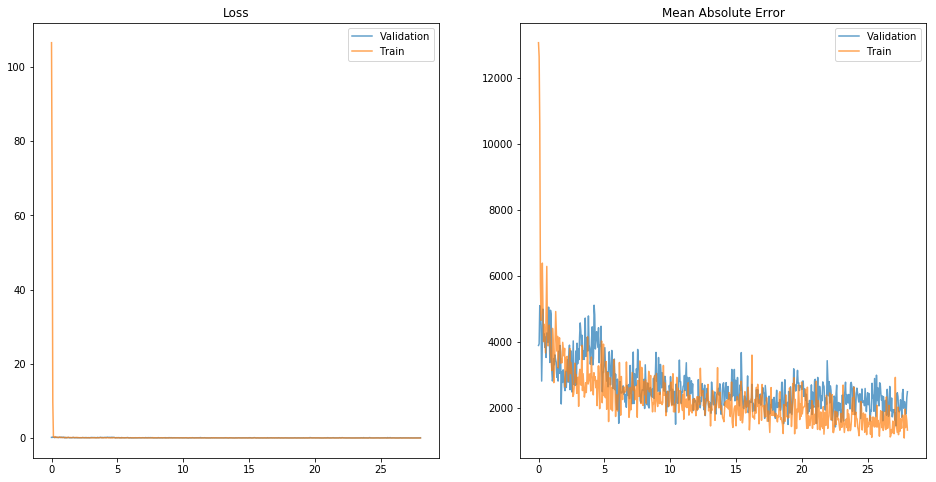

Training finished, final eval:





	Loss:	0.04872
	MAE:	2032.79195


In [106]:
train_and_eval(model, opt, 100, data_train, data_val, 64, 1000, early_stopping_thrshold=5)

### Task 3.2: Actually make it work

Your main task is to use some of the tricks you've learned on the network and analyze if you can improve __validation MAE__.

Try __at least 3 options__ from the list below for a passing grade. If you're into 

#### A) CNN architecture

All the tricks you know about dense and convolutional neural networks apply here as well.
* Dropout. Nuff said.
* Batch Norm. This time it's `nn.BatchNorm1d`
* Parallel convolution layers. The idea is that you apply several nn.Conv1d to the same embeddings and concatenate output channels.
* More layers, more neurons, ya know...


#### B) Play with pooling

There's more than one way to do max pooling:
* Max over time - our `GlobalMaxPooling`
* Average over time (excluding PAD)
* Softmax-pooling:
$$ out_{i, t} = \sum_t {h_{i,t} \cdot {{e ^ {h_{i, t}}} \over \sum_\tau e ^ {h_{j, \tau}} } }$$

* Attentive pooling
$$ out_{i, t} = \sum_t {h_{i,t} \cdot Attn(h_t)}$$

, where $$ Attn(h_t) = {{e ^ {NN_{attn}(h_t)}} \over \sum_\tau e ^ {NN_{attn}(h_\tau)}}  $$
and $NN_{attn}$ is a small neural network


The optimal score is usually achieved by concatenating several different poolings, including several attentive pooling with different $NN_{attn}$

#### C) Fun with embeddings

It's not always a good idea to train embeddings from scratch. Here's a few tricks:

* Use a pre-trained word2vec from [here](http://ahogrammer.com/2017/01/20/the-list-of-pretrained-word-embeddings/) or [here](http://mccormickml.com/2016/04/12/googles-pretrained-word2vec-model-in-python/).
* Start with pre-trained embeddings, then fine-tune them with gradient descent
* Use the same embedding matrix in title and desc vectorizer

#### D) Going recurrent

We've already learned that recurrent networks can do cool stuff in sequence modelling. Turns out, they're not useless for classification as well. With some tricks of course..

* Like convolutional layers, LSTM should be pooled into a fixed-size vector with some of the poolings.
  * Please bear in mind that while convolution uses [batch, units, time] dim order, 
    recurrent units are built for [batch, time, unit]. You may need to `torch.transpose`.

* Since you know all the text in advance, use bidirectional RNN
  * Run one LSTM from left to right
  * Run another in parallel from right to left 
  * Concatenate their output sequences along unit axis (dim=-1)

* It might be good idea to mix convolutions and recurrent layers differently for title and description


#### E) Optimizing seriously

* You don't necessarily need 100 epochs. Use early stopping. If you've never done this before, take a look at [keras](https://github.com/keras-team/keras/blob/master/keras/callbacks.py#L461) for inspiration.
  * In short, train until you notice that validation
  * Maintain the best-on-validation snapshot via `model.state_dict`
  * Plotting learning curves is usually a good idea

### A short report

We used **batch_size=64** in every model except for RNN due to memory constraints. We used **1000** training batches in each epoch. The baseline architecture and training procedure gave around **2559.2** validation MAE, after implementing early stopping and best state dict saving, MAE decreased to **2151.1**. RNN variant was much slower to train (around 3-4 times slower) and did not achieve lower MAE, we tried both LSTM and GRU bidirectional 3-layered vairiants with and without batchnorm, attentive pooling and **batch_size=16**. Early stopping was triggered at **2476.3** best validation MAE in the best recurrent model we obtained. With a slightly larger CNN model with batch norm in encoders (see Text Encoder above) we achieved **2032.8** MAE with GlobalMaxPooling, **2044.9** MAE with global average pooling, **2026.1** MAE with attentive pooling, **2380.3** MAE with softmax pooling

<table>
<tr>
<th>Model</th>
<th>Validation MAE</th>
</tr>
<tr>
<td>Baseline</td>
<td>2559.2</td>
</tr>
<tr>
<td>Baseline + early stopping + best dict saving</td>
<td>2151.1</td>
</tr>
<tr>
<td>LSTM</td>
<td>2476.3</td>
</tr>
<tr>
<td>CNN Larger + BN + softmax pooling</td>
<td>2380.3</td>
</tr>
<tr>
<td>CNN Larger + BN + global average pooling</td>
<td>2044.9</td>
</tr>
<tr>
<td>CNN Larger + BN + attentive pooling</td>
<td>2026.1</td>
</tr>
<tr>
<td>CNN Larger + BN + global max pooling</td>
<td>2032.8</td>
</tr>
</table>